# 互联网金融风控中的用户贷款欺诈风险发现（基于lending club数据集）2-建模


In [1]:
'''
@author: chenbingyan
@connect: bjchenbingyan@126.com
@site: http://www.intelligentdata.cn/ 
@date: Feb. 11,2018
'''
import numpy as np
import pandas as pd
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./LoanStats.csv', encoding='utf-8')
df.head()

,loan_amnt,int_rate,emp_length,annual_inc,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,...,title_Moving and relocation,title_Other,title_Vacation,title_unknown,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay
0,14400,7.99,9,135000.0,1.0,0,6.60,1,0,15,...,0,0,0,0,0,1,1,0,1,0
1,4500,12.74,6,32000.0,1.0,0,29.93,0,1,7,...,0,0,0,0,0,1,1,0,1,0
2,3600,11.39,10,89712.0,1.0,0,20.30,0,0,16,...,0,0,0,0,1,0,1,0,1,0
3,7000,5.32,2,85000.0,1.0,0,12.80,1,0,14,...,0,0,0,0,0,1,1,0,1,0
4,12000,16.99,0,30000.0,1.0,0,9.26,0,0,3,...,0,0,0,0,0,1,1,0,1,0


In [3]:
df.fillna(0.0, inplace=True)
df.fillna(0, inplace=True)

In [4]:
# 0-1标准化
df = (df - df.min()) / (df.max() - df.min())
df.head()

,loan_amnt,int_rate,emp_length,annual_inc,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,...,title_Moving and relocation,title_Other,title_Vacation,title_unknown,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,disbursement_method_Cash,disbursement_method_DirectPay
0,0.343590,0.104012,0.9,0.001227,1.0,0.0,0.00760,0.02381,0.0,0.154639,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.089744,0.289053,0.6,0.000291,1.0,0.0,0.03093,0.00000,0.2,0.072165,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.066667,0.236463,1.0,0.000816,1.0,0.0,0.02130,0.00000,0.0,0.164948,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.153846,0.000000,0.2,0.000773,1.0,0.0,0.01380,0.02381,0.0,0.144330,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.282051,0.454616,0.0,0.000273,1.0,0.0,0.01026,0.00000,0.0,0.030928,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


#处理数据不平衡问题
negative_df = df[df.loan_status == 0]
positive_df = df[df.loan_status == 1]

len(negative_df)

len(positive_df)

#由于负样本只有正样本的3%，所对正样本进行降采样，对负样本进行过采样
positive_df = positive_df.sample(frac=0.06, random_state=1)

df = pd.concat([negative_df, positive_df, negative_df], axis=0)

In [5]:
len(df)

417345

In [6]:
df = df.sample(frac=1, random_state=1)
df = df.reset_index(drop=True)

In [7]:
Y = df.loan_status
X = df.drop('loan_status', axis=1, inplace=False)

In [8]:
Y.shape

(417345,)

In [9]:
Y.value_counts()

1.0    407615
0.0      9730
Name: loan_status, dtype: int64

In [10]:
X.shape

(417345, 103)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

## Xgboost分类模型

param_grid = { 'n_estimators':[150, 200], 'max_depth':[11, 13], 'learning_rate':[0.1, 0.15, 0.2],
              'reg_alpha':[0.5, 1], 'reg_lambda':[0.5, 1]
}

est = GridSearchCV(xgb.XGBRegressor(subsample=0.8, silent=True, seed=0,objective='binary:logistic', gamma=0, missing=None, 
                                    colsample_bytree=0.3,scale_pos_weight=1, min_child_weight=1, max_delta_step=0, base_socre=0.5), 
                   param_grid, refit=True)
est.fit(X_train, y_train, eval_metric='auc', verbose=True, eval_set=[(X_test, y_test)], early_stopping_rounds=1000)
best_params = est.best_params_
best_params
'''
{'learning_rate': 0.1,
 'max_depth': 13,
 'n_estimators': 200,
 'reg_alpha': 0.5,
 'reg_lambda': 1}

'''

In [24]:
# 根据GridSearchCV选出的最优模型参数再训练一次模型
# 经过多次尝试，最好的模型参数如下
clf = xgb.XGBClassifier(n_estimators=300, max_depth=13, learning_rate=0.15, subsample=0.8, silent=True, seed=1,
                           objective='binary:logistic', reg_alpha=0.5, reg_lambda=1, gamma=0, missing=None, colsample_bytree=0.3,
                       scale_pos_weight=1, min_child_weight=1, max_delta_step=0, base_socre=0.5)
#scale_pos_weight: 是用来调节正负样本不均衡问题的，用助于样本不平衡时训练的收敛。 

In [25]:
clf.fit(X_train, y_train, eval_metric='auc', verbose=True, eval_set=[(X_test, y_test)], early_stopping_rounds=100)
clf.score(X_test, y_test)

[0]	validation_0-auc:0.612585
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.695475
[2]	validation_0-auc:0.719182
[3]	validation_0-auc:0.770715
[4]	validation_0-auc:0.784238
[5]	validation_0-auc:0.78699
[6]	validation_0-auc:0.785371
[7]	validation_0-auc:0.789306
[8]	validation_0-auc:0.789539
[9]	validation_0-auc:0.789408
[10]	validation_0-auc:0.79491
[11]	validation_0-auc:0.79636
[12]	validation_0-auc:0.79962
[13]	validation_0-auc:0.795243
[14]	validation_0-auc:0.792566
[15]	validation_0-auc:0.790056
[16]	validation_0-auc:0.792494
[17]	validation_0-auc:0.789945
[18]	validation_0-auc:0.792797
[19]	validation_0-auc:0.791997
[20]	validation_0-auc:0.792074
[21]	validation_0-auc:0.790636
[22]	validation_0-auc:0.792543
[23]	validation_0-auc:0.795149
[24]	validation_0-auc:0.79581
[25]	validation_0-auc:0.798761
[26]	validation_0-auc:0.800192
[27]	validation_0-auc:0.797179
[28]	validation_0-auc:0.802993
[29]	validation_0-auc:0.811379
[30]	validation_0-au

0.9785304886230759

In [14]:
# 计算KS值
from scipy.stats import ks_2samp
test_df = pd.DataFrame()
test_df['prediction'] = clf.predict(X_test)
test_df['label'] = np.array(y_test)
ks_2samp(test_df.prediction, test_df.label)

Ks_2sampResult(statistic=0.02173253250694866, pvalue=3.932182228344816e-26)

In [15]:
feature_importances = clf.feature_importances_

In [16]:
indices = np.argsort(feature_importances)[-25:]
indices

array([45,  1, 57, 32, 26, 48, 28, 66, 40, 21, 43, 44,  3, 38, 33, 27, 10,
       17, 11, 39,  5, 31, 13, 15, 14], dtype=int64)

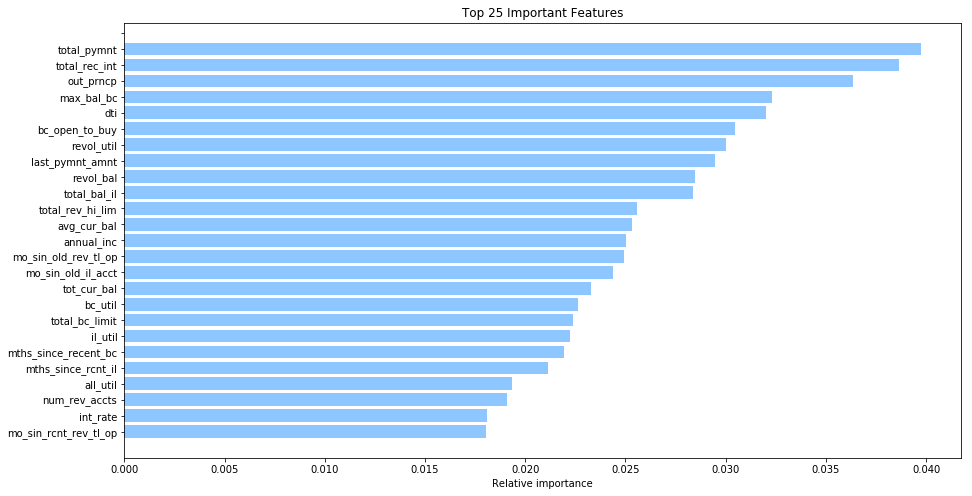

In [17]:
sns.set_style()
fig = plt.figure(figsize=(15, 8))
plt.barh(np.arange(25), feature_importances[indices], color='dodgerblue', alpha=0.5)
plt.yticks(np.arange(25+0.5), np.array(X.columns)[indices])
plt.xlabel('Relative importance')
plt.title('Top 25 Important Features')
plt.savefig('./Top 25 Important Features-.png')
plt.show()

## 进一步评估模型

ROC(Receiver Operating Characteristic Curve):接受者操作特征曲线。
ROC曲线及AUC系数主要用来检验模型对客户进行正确排序的能力。ROC曲线描述了在一定累计好客户比例下的累计坏客户的比例，模型的分辨能力越强，ROC曲线越往左上角靠近。AUC系数表示ROC曲线下方的面积。AUC系数越高，模型的风险区分能力越强。

KS（Kolmogorov-Smirnov）检验:K－S检验主要是验证模型对违约对象的区分能力，通常是在模型预测全体样本的信用评分后，将全体样本按违约与非违约分为两部分，然后用KS统计量来检验这两组样本信用评分的分布是否有显著差异。


ROC值一般在0.5-1.0之间。值越大表示模型判断准确性越高，即越接近1越好。ROC=0.5表示模型的预测能力与随机结果没有差别。
KS值表示了模型将+和-区分开来的能力。值越大，模型的预测准确性越好。一般，KS>0.2即可认为模型有比较好的预测准确性。

要弄明白ks值和auc值的关系首先要弄懂roc曲线和ks曲线是怎么画出来的。其实从某个角度上来讲ROC曲线和KS曲线是一回事，只是横纵坐标的取法不同而已。拿逻辑回归举例，模型训练完成之后每个样本都会得到一个类概率值（注意是类似的类），把样本按这个类概率值排序后分成10等份，每一份单独计算它的真正率和假正率，然后计算累计概率值，用真正率和假正率的累计做为坐标画出来的就是ROC曲线，用10等分做为横坐标，用真正率和假正率的累计值分别做为纵坐标就得到两个曲线，这就是KS曲线。AUC值就是ROC曲线下放的面积值，而ks值就是ks曲线中两条曲线之间的最大间隔距离。由于ks值能找出模型中差异最大的一个分段，因此适合用于cut_off，像评分卡这种就很适合用ks值来评估。但是ks值只能反映出哪个分段是区分最大的，而不能总体反映出所有分段的效果，因而AUC值更能胜任。

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

In [19]:
cv = StratifiedKFold(np.array(Y), n_folds=8)

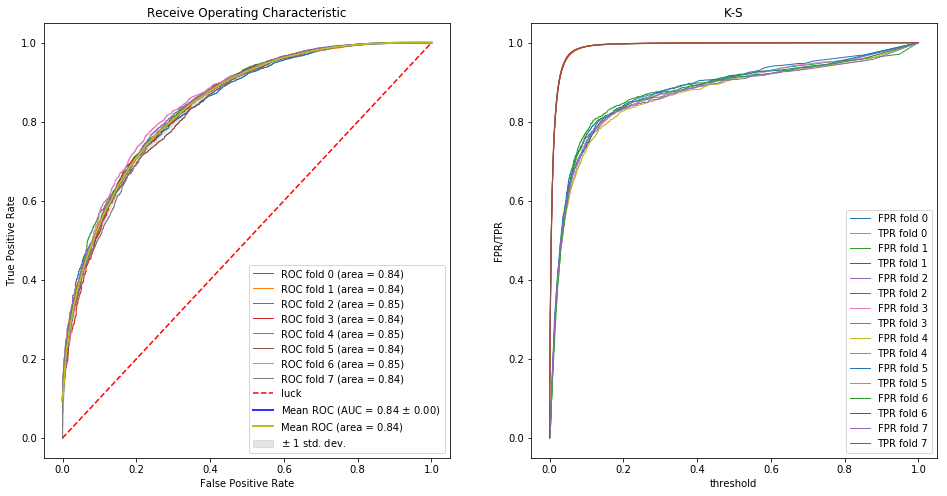

In [20]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
ks_values = []
sns.set_style()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, (train, test) in enumerate(cv):
    X_train = X.iloc[train,:]
    y_train = Y[train]
    X_test = X.iloc[test,:]
    y_test = Y[test]
    '''
    xg_train = xgb.DMatrix(X_train, y_train)
    xg_test = xgb.DMatrix(X_test, y_test)
    param = {'n_estimator':200, 'max_depth':13, 'learning_rate':0.1, 'objective':'binary:logistic', 'reg_alpha':0.5, 'reg_lambda':1,'gamma':0,
            'silent':1, 'missing':None, 'colsample_bytree':0.3, 'scale_pos_weight':1, 'min_child_weight':1, 'max_delta_step':0, 
             'base_socre':0.5, 'seed':1, 'subsample':0.8}
    clf = xgb.train(param, xg_train, 30, [(xg_train, 'train'), (xg_test, 'test')], early_stopping_rounds=10)
    y_predict = clf.predict(xg_test)
    '''
    clf = xgb.XGBClassifier(n_estimators=200, max_depth=13, learning_rate=0.1, subsample=0.8, silent=1, seed=1,
                           objective='binary:logistic', reg_alpha=0.5, reg_lambda=1, gamma=0, missing=None, colsample_bytree=0.3,
                       scale_pos_weight=1, min_child_weight=1, max_delta_step=0, base_socre=0.5)
    clf.fit(X_train, y_train, eval_metric='auc', verbose=False, eval_set=[(X_test, y_test)], early_stopping_rounds=100)
    y_predict = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    # ROC
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    # KS
    ax2.plot(1-thresholds, fpr, lw=1, label='FPR fold %d'%(i))
    ax2.plot(1-thresholds, tpr, lw=1, label='TPR fold %d'%(i))
    ks_value = np.abs(fpr - tpr)
    max_ks_value = np.max(ks_value)
    ks_values.append(max_ks_value)
# ROC    
ax1.plot([0, 1], [0, 1], '--', color='red', label='luck')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
ax1.plot(mean_fpr, mean_tpr, '-', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
ax1.set(title='Receive Operating Characteristic', xlabel='False Positive Rate', ylabel='True Positive Rate', 
        xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax1.legend(loc='lower right')
# KS
ax2.set(title='K-S', xlabel='threshold', ylabel='FPR/TPR', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax2.legend(loc='lower right')

plt.savefig('ROC&KS-.png')
plt.show()

In [21]:
mean_ks_value = np.mean(ks_values)
mean_ks_value

0.5184700896952773